In [2]:
import torch
import math
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import scipy
from sklearn.manifold import TSNE

In [4]:
neural_data=np.loadtxt('superchris_odor_spike_mat.csv',delimiter=',',skiprows=6,usecols=range(5,51))
odor_data=np.loadtxt('superchris_odor_spike_mat.csv',delimiter=',',skiprows=6,usecols=1)

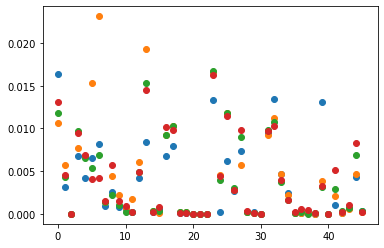

In [5]:
odor1_all=np.sum(neural_data[odor_data==1],axis=0)/neural_data[odor_data==1].shape[0]
odor2_all=np.sum(neural_data[odor_data==2],axis=0)/neural_data[odor_data==2].shape[0]
odor3_all=np.sum(neural_data[odor_data==3],axis=0)/neural_data[odor_data==3].shape[0]
odor4_all=np.sum(neural_data[odor_data==4],axis=0)/neural_data[odor_data==4].shape[0]
plt.scatter(np.arange(46),odor1_all)
plt.scatter(np.arange(46),odor2_all)
plt.scatter(np.arange(46),odor3_all)
plt.scatter(np.arange(46),odor4_all)

In [80]:
time_bin=150
index_odor1=neural_data[odor_data==1].shape[0]%time_bin
odor1_subset=neural_data[odor_data==1][:-index_odor1,:].reshape((-1,time_bin,46))
odor1_subset_sum=np.sum(odor1_subset,axis=1)
odor1_label=np.zeros(odor1_subset_sum.shape[0])
odor1_label[:]=1

index_odor1=neural_data[odor_data==2].shape[0]%time_bin
odor1_subset=neural_data[odor_data==2][:-index_odor1,:].reshape((-1,time_bin,46))
odor2_subset_sum=np.sum(odor1_subset,axis=1)
odor2_label=np.zeros(odor2_subset_sum.shape[0])
odor2_label[:]=2

index_odor1=neural_data[odor_data==3].shape[0]%time_bin
odor1_subset=neural_data[odor_data==3][:-index_odor1,:].reshape((-1,time_bin,46))
odor3_subset_sum=np.sum(odor1_subset,axis=1)
odor3_label=np.zeros(odor3_subset_sum.shape[0])
odor3_label[:]=3

index_odor1=neural_data[odor_data==4].shape[0]%time_bin
odor1_subset=neural_data[odor_data==4][:-index_odor1,:].reshape((-1,time_bin,46))
odor4_subset_sum=np.sum(odor1_subset,axis=1)
odor4_label=np.zeros(odor4_subset_sum.shape[0])
odor4_label[:]=4

index_odor1=neural_data[odor_data==5].shape[0]%time_bin
odor1_subset=neural_data[odor_data==5][:-index_odor1,:].reshape((-1,time_bin,46))
odor5_subset_sum=np.sum(odor1_subset,axis=1)
odor5_label=np.zeros(odor5_subset_sum.shape[0])
odor5_label[:]=5


spike_data_final=np.concatenate((odor1_subset_sum,odor2_subset_sum,odor3_subset_sum,odor4_subset_sum,odor5_subset_sum),axis=0)
odor_data_final=np.concatenate((odor1_label,odor2_label,odor3_label,odor4_label,odor5_label),axis=0)
spike_data_final=torch.from_numpy(spike_data_final)
odor_data_final=torch.from_numpy(odor_data_final)
print(spike_data_final.shape)

torch.Size([1872, 46])


In [162]:
150*0.001

0.15

In [85]:
batch_size=100
train_X=torch.split(spike_data_final,batch_size)
train_Y=torch.split(odor_data_final,batch_size)

class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=128):
        super(VAE, self).__init__()
        
        # Encoder layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2=nn.Linear(hidden_dim,hidden_dim)
        self.fc2_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder layers
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc_new=nn.Linear(hidden_dim,hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)
        self.latent_dim=latent_dim
        self.input_dim=input_dim
        
    def encode(self, x):
        
        h0 = torch.relu(self.fc1(x))
        h1 = torch.relu(self.fc2(h0))
        mu = self.fc2_mu(h1)
        logvar = self.fc2_logvar(h1)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def sample_data(self,sample_data_size):
        sample_z = torch.randn(sample_data_size,latent_dim)
        sample_data_from_z=self.decode(sample_z.double())
        return sample_data_from_z
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        h4 = torch.relu(self.fc_new(h3))
        h5=torch.relu(self.fc4(h4))
        final_output=torch.relu(h5)
        return final_output
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar,z

# Loss function (binary cross-entropy + KL divergence)
def loss_function(recon_x, x, mu, logvar,beta=1):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    # KL divergence between encoder's distribution and standard Gaussian
    KLD = -beta*0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD

# Hyperparameters
input_dim = 46
latent_dim = 2
hidden_dim = 128
learning_rate = 1e-3
epochs = 100

# Initialize model, optimizer
model = VAE(input_dim=input_dim, latent_dim=latent_dim, hidden_dim=hidden_dim).double()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_history=[]

# Training loop
for epoch in tqdm(range(epochs)):
    for i in range(len(train_X)):
        model.train()
        optimizer.zero_grad()
        recon_batch, mu, logvar,z = model(train_X[i])
        if epoch < 80:
            beta=0
        else:
            beta=0.5
        loss = loss_function(recon_batch, train_X[i], mu, logvar,beta)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.detach().numpy())
    print(loss)

  4%|▍         | 4/100 [00:00<00:06, 15.97it/s]

tensor(2622.6509, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2436.9668, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2467.2642, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2401.5555, dtype=torch.float64, grad_fn=<AddBackward0>)


  8%|▊         | 8/100 [00:00<00:05, 17.62it/s]

tensor(2291.5827, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2233.7785, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2164.8378, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2105.4520, dtype=torch.float64, grad_fn=<AddBackward0>)


 10%|█         | 10/100 [00:00<00:05, 16.40it/s]

tensor(2071.0941, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(2041.2632, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1987.1194, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1938.1825, dtype=torch.float64, grad_fn=<AddBackward0>)


 16%|█▌        | 16/100 [00:00<00:04, 19.16it/s]

tensor(1928.0580, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1918.9084, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1904.9458, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1892.9315, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1885.5649, dtype=torch.float64, grad_fn=<AddBackward0>)


 21%|██        | 21/100 [00:01<00:04, 19.07it/s]

tensor(1869.7381, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1857.9621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1687.0105, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1669.4449, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1639.3348, dtype=torch.float64, grad_fn=<AddBackward0>)


 26%|██▌       | 26/100 [00:01<00:03, 19.21it/s]

tensor(1616.6703, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1612.0914, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1580.9207, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1577.9438, dtype=torch.float64, grad_fn=<AddBackward0>)


 30%|███       | 30/100 [00:01<00:03, 18.71it/s]

tensor(1561.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1561.2166, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1550.6435, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1556.2305, dtype=torch.float64, grad_fn=<AddBackward0>)


 34%|███▍      | 34/100 [00:01<00:03, 18.22it/s]

tensor(1541.9615, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1550.5868, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1536.1544, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1547.7144, dtype=torch.float64, grad_fn=<AddBackward0>)


 39%|███▉      | 39/100 [00:02<00:03, 18.69it/s]

tensor(1532.1165, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1540.8032, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1529.8884, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1536.3892, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1525.0626, dtype=torch.float64, grad_fn=<AddBackward0>)


 42%|████▏     | 42/100 [00:02<00:03, 19.26it/s]

tensor(1531.3379, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1518.2056, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1525.5480, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1512.6851, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1518.6170, dtype=torch.float64, grad_fn=<AddBackward0>)


 47%|████▋     | 47/100 [00:02<00:02, 17.87it/s]

tensor(1509.6063, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1513.2663, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1506.8869, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1508.1401, dtype=torch.float64, grad_fn=<AddBackward0>)


 51%|█████     | 51/100 [00:02<00:02, 17.54it/s]

tensor(1506.4470, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1504.7048, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1503.3148, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1501.9374, dtype=torch.float64, grad_fn=<AddBackward0>)


 55%|█████▌    | 55/100 [00:03<00:02, 17.39it/s]

tensor(1499.8922, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1499.6044, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1497.3507, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1500.5464, dtype=torch.float64, grad_fn=<AddBackward0>)


 59%|█████▉    | 59/100 [00:03<00:02, 17.61it/s]

tensor(1494.1432, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1496.5931, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1495.6984, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1497.2607, dtype=torch.float64, grad_fn=<AddBackward0>)


 63%|██████▎   | 63/100 [00:03<00:02, 17.29it/s]

tensor(1487.9037, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1494.0133, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1493.1361, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1496.3689, dtype=torch.float64, grad_fn=<AddBackward0>)


 68%|██████▊   | 68/100 [00:03<00:01, 18.81it/s]

tensor(1497.4621, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1496.1121, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1504.0969, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1497.8711, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1499.1945, dtype=torch.float64, grad_fn=<AddBackward0>)


 72%|███████▏  | 72/100 [00:03<00:01, 18.85it/s]

tensor(1490.7477, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1488.1371, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1491.7834, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1486.1658, dtype=torch.float64, grad_fn=<AddBackward0>)


 76%|███████▌  | 76/100 [00:04<00:01, 18.74it/s]

tensor(1486.7130, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1490.5662, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1494.1520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1486.9866, dtype=torch.float64, grad_fn=<AddBackward0>)


 81%|████████  | 81/100 [00:04<00:01, 18.68it/s]

tensor(1481.0064, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1475.9558, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1475.6409, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1698.8753, dtype=torch.float64, grad_fn=<AddBackward0>)


 85%|████████▌ | 85/100 [00:04<00:00, 16.53it/s]

tensor(1684.6906, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1683.5205, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1681.1520, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1659.1535, dtype=torch.float64, grad_fn=<AddBackward0>)


 87%|████████▋ | 87/100 [00:04<00:00, 15.46it/s]

tensor(1643.6066, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1648.6173, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1657.4386, dtype=torch.float64, grad_fn=<AddBackward0>)


 91%|█████████ | 91/100 [00:05<00:00, 15.77it/s]

tensor(1658.2006, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1650.6473, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1644.3193, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1650.8955, dtype=torch.float64, grad_fn=<AddBackward0>)


 96%|█████████▌| 96/100 [00:05<00:00, 17.64it/s]

tensor(1645.1356, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1653.6152, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1643.1637, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1637.0440, dtype=torch.float64, grad_fn=<AddBackward0>)


100%|██████████| 100/100 [00:05<00:00, 17.91it/s]

tensor(1641.5778, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1654.3771, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1651.9535, dtype=torch.float64, grad_fn=<AddBackward0>)
tensor(1645.1127, dtype=torch.float64, grad_fn=<AddBackward0>)


In [180]:
len(train_X)

19

Text(0.5, 0, 'Epochs')

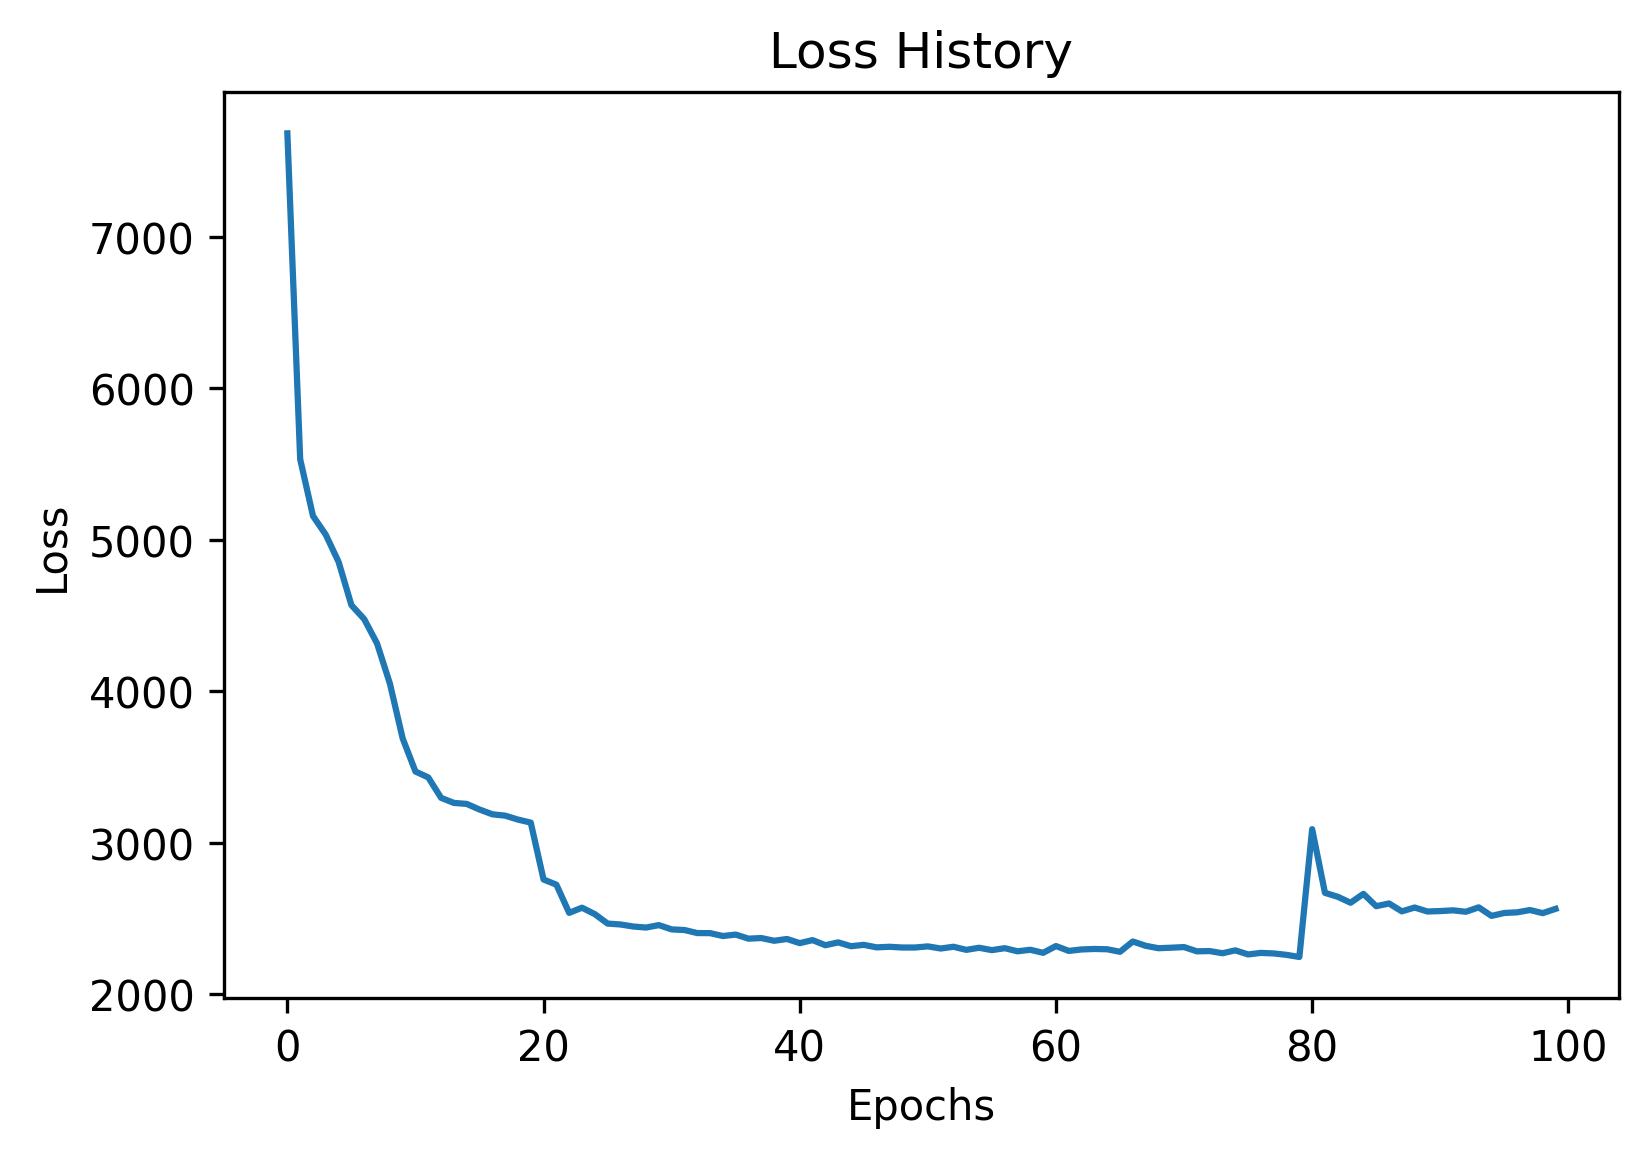

In [183]:
plt.figure(dpi=300)
plt.plot(loss_history[::19])
plt.title('Loss History')
plt.ylabel('Loss')
plt.xlabel('Epochs')

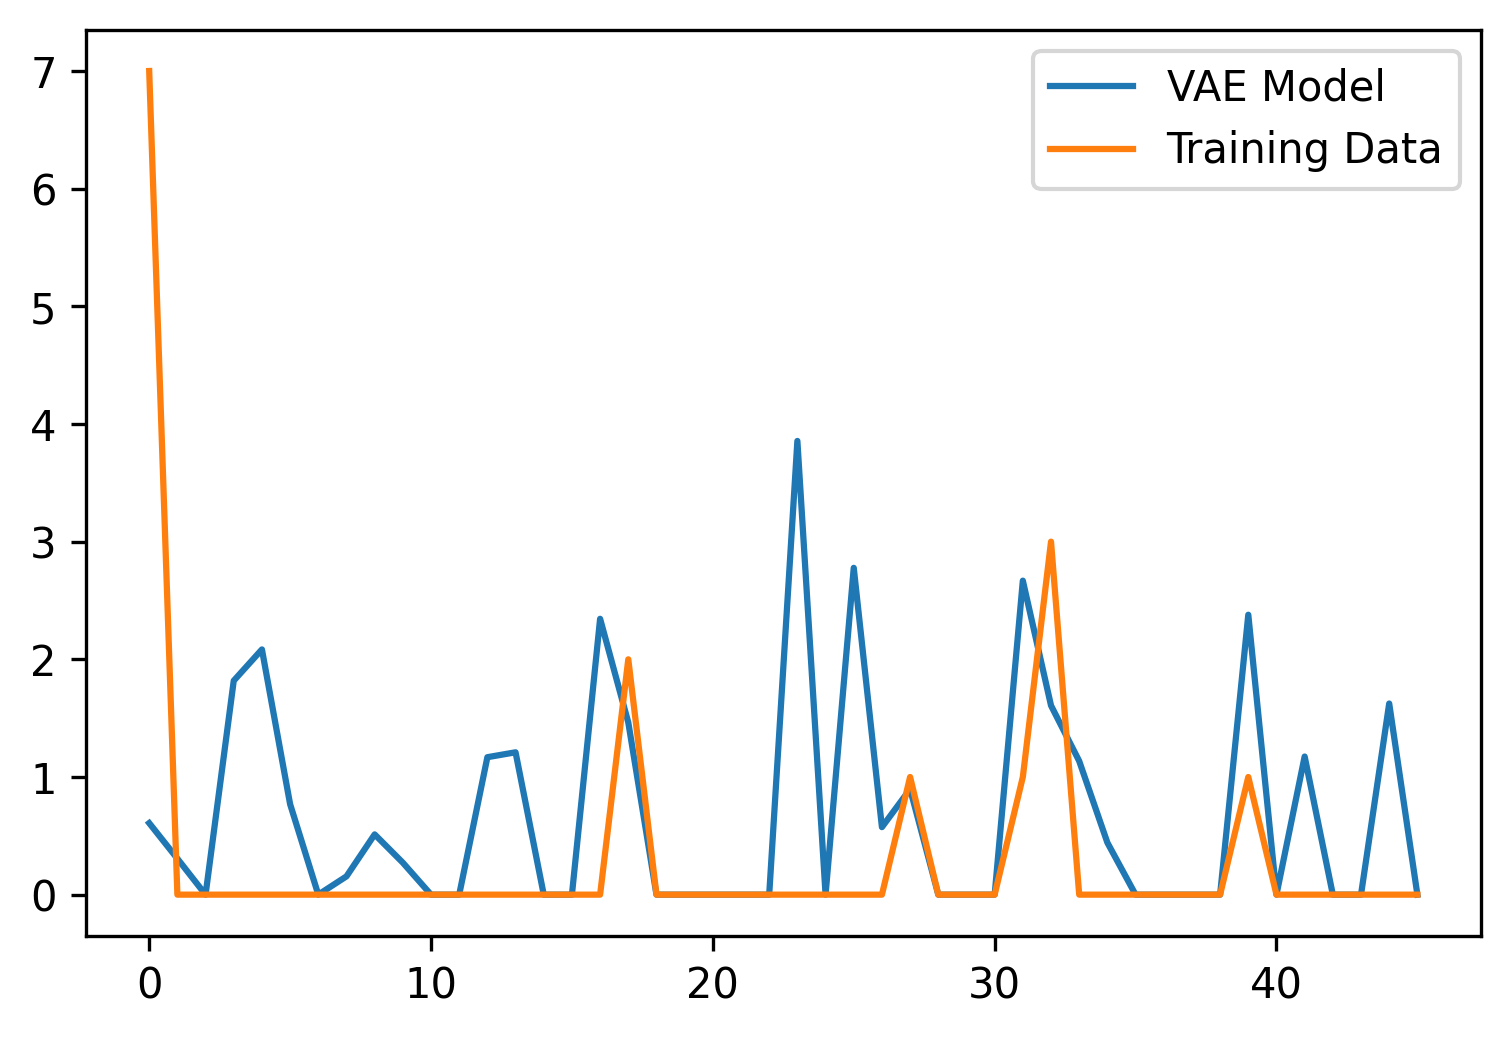

In [86]:
Z_train_X=model.encode(train_X[0])
X_hat_from_Z=model.decode(Z_train_X[0])

plt.figure(dpi=300)
plt.plot(X_hat_from_Z[0].detach().numpy(),label='VAE Model')
plt.plot(train_X[1][0].detach().numpy(),label='Training Data')
plt.legend()

In [87]:
recon_batch, mu, logvar,z = model(spike_data_final)
#Latent_Space=TSNE(n_components=2, learning_rate='auto',init='random', perplexity=3).fit_transform(z.detach().numpy())
Latent_Space=z.detach().numpy()

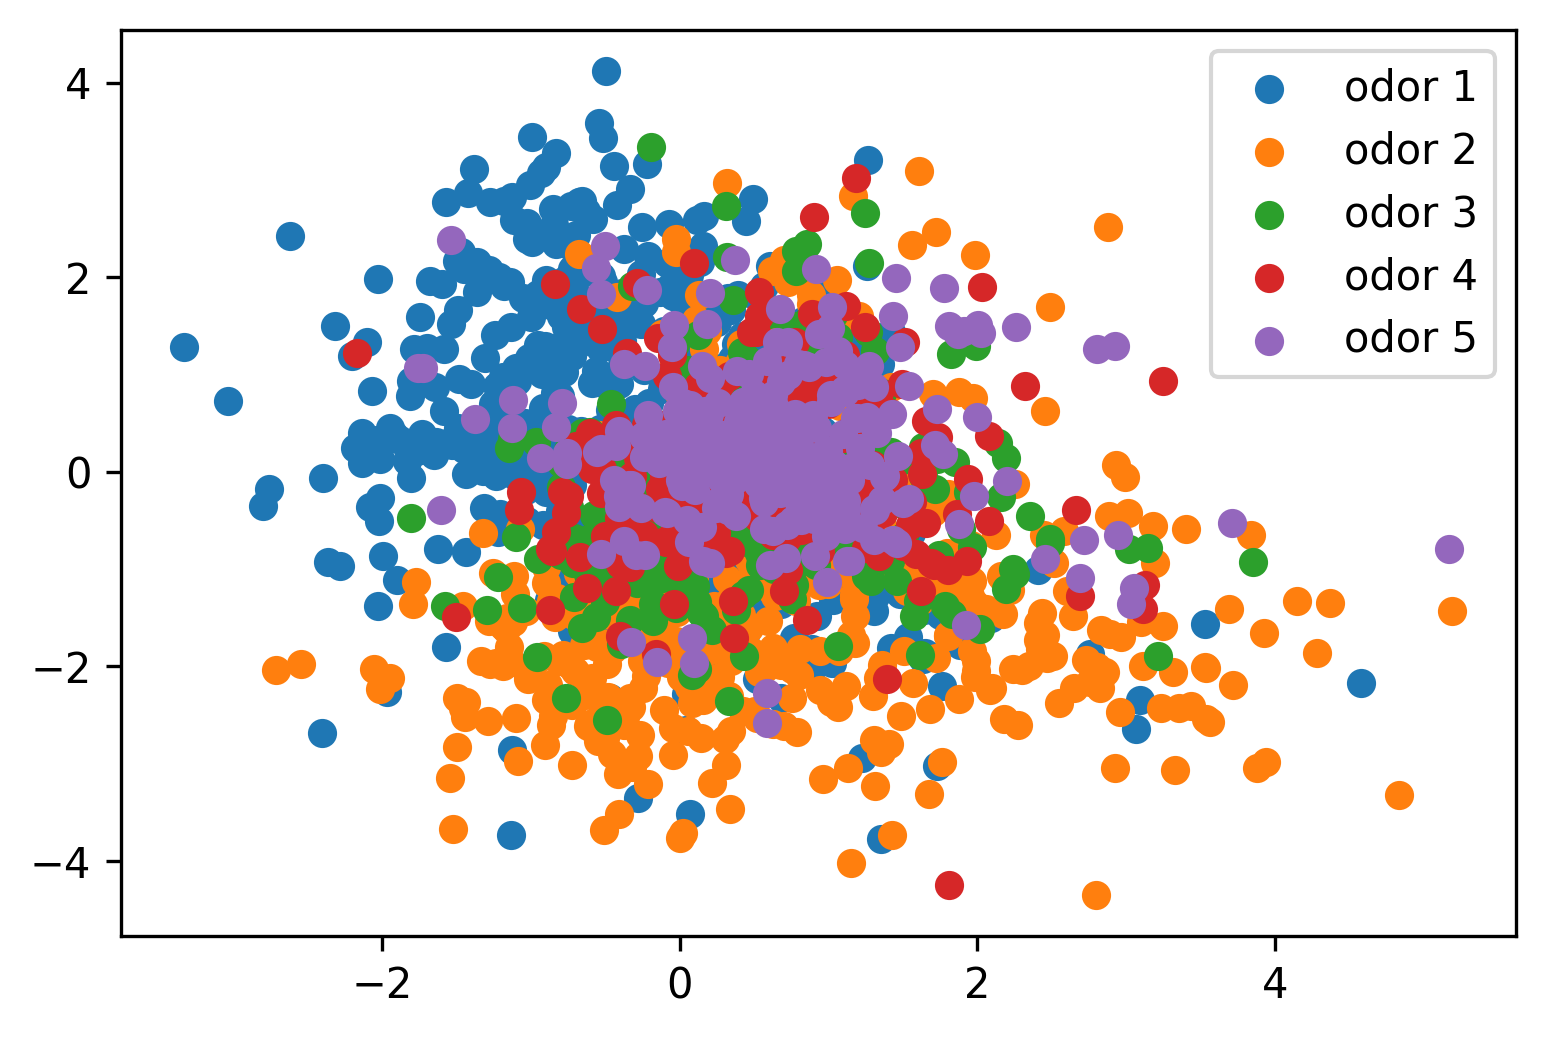

In [94]:
plt.figure(dpi=300)
for i in range(1,6):
    plt.scatter(Latent_Space[odor_data_final==i][:,0],Latent_Space[odor_data_final==i][:,1],label='odor '+str(i))
plt.legend()

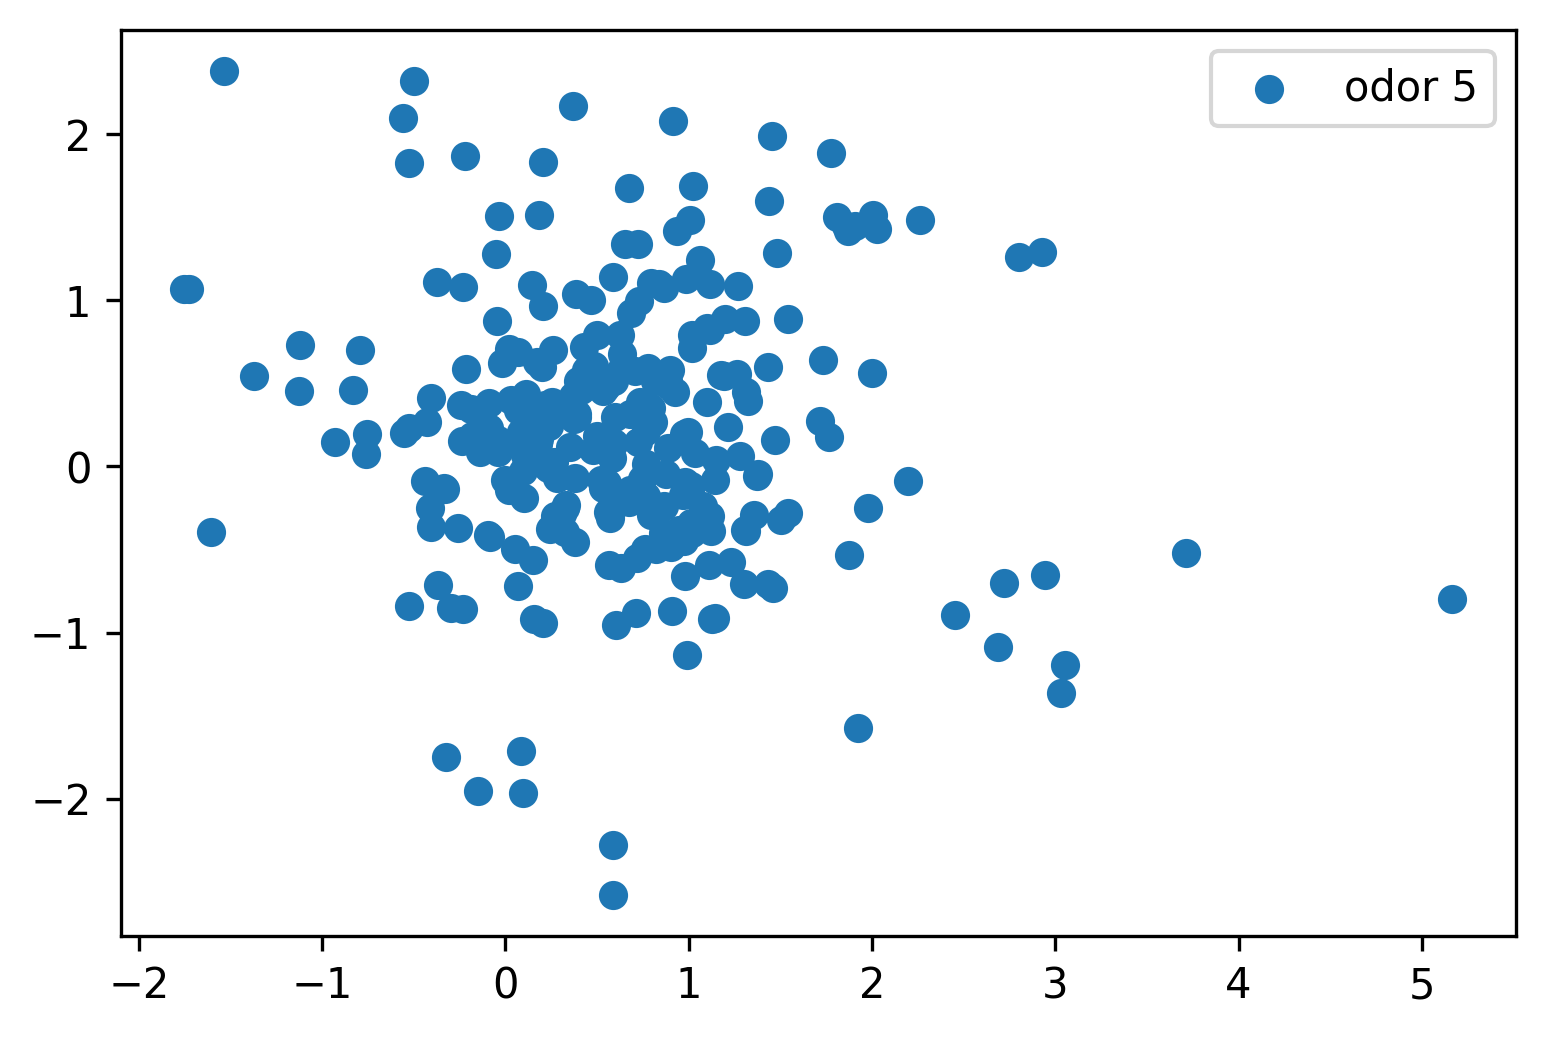

In [118]:
plt.figure(dpi=300)
i=5
plt.scatter(Latent_Space[odor_data_final==i][:,0],Latent_Space[odor_data_final==i][:,1],label='odor '+str(i))
plt.legend()

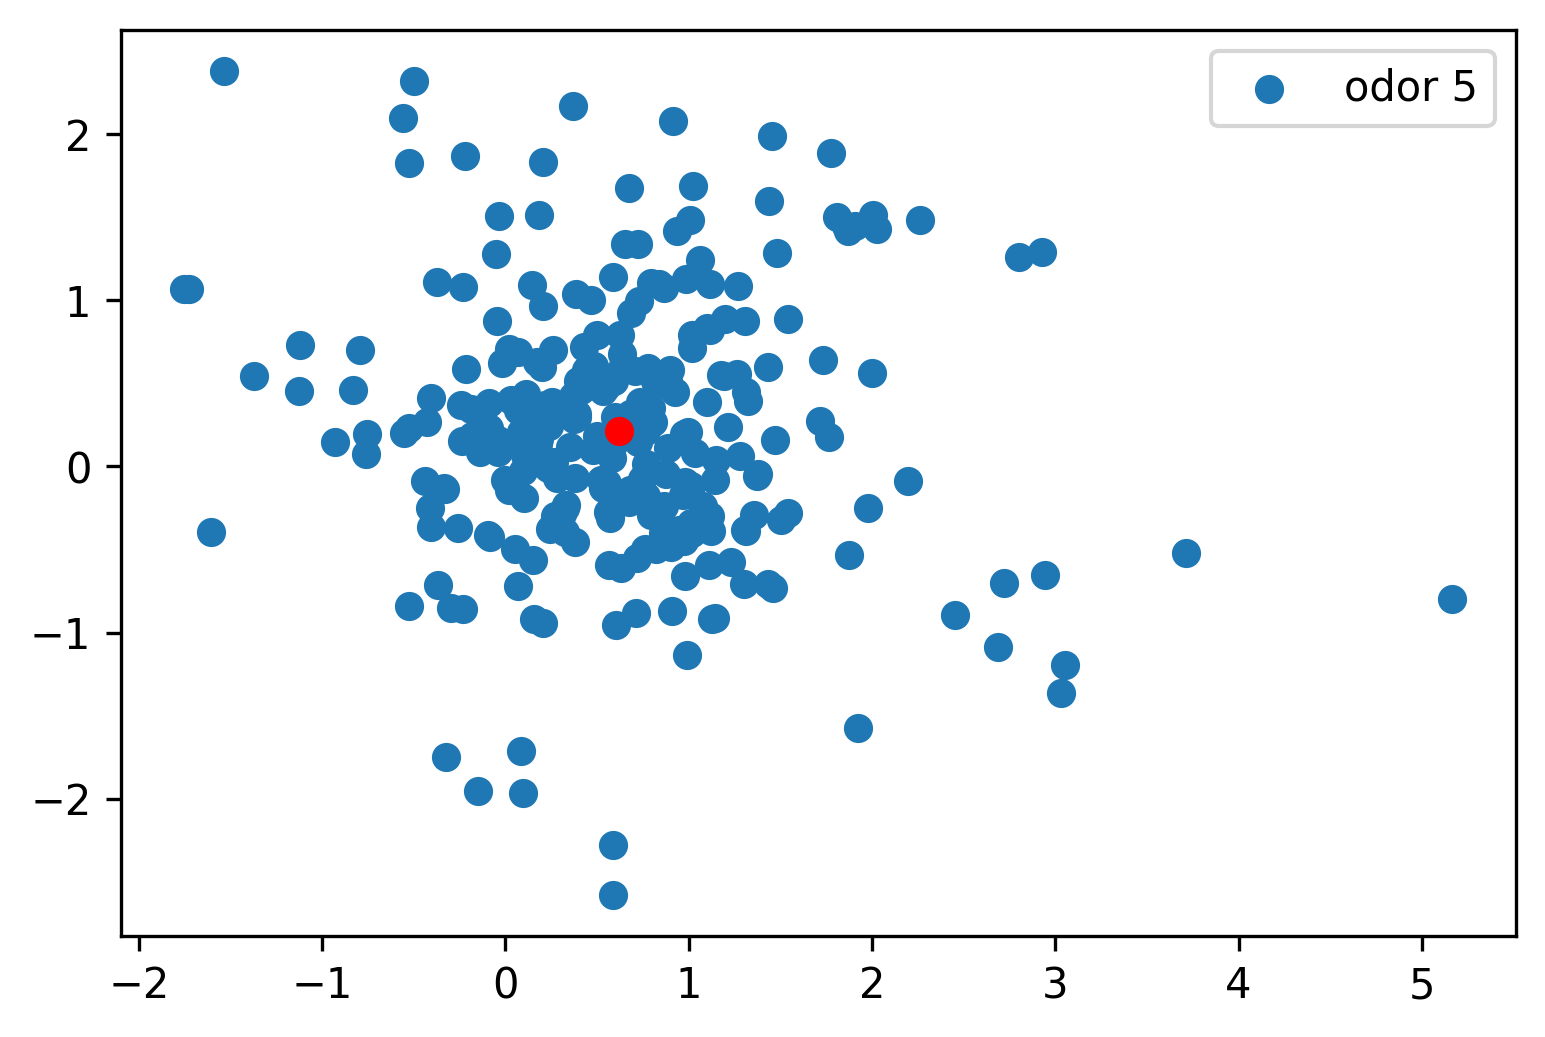

In [124]:
from sklearn.cluster import KMeans
i=5

kmeans=KMeans(n_clusters=1)
kmeans.fit(Latent_Space[odor_data_final==i])
centroids  = kmeans.cluster_centers_
plt.figure(dpi=300)
plt.scatter(Latent_Space[odor_data_final==i][:,0],Latent_Space[odor_data_final==i][:,1],label='odor '+str(i))
plt.scatter(centroids[0,0],centroids[0,1],color='r')
plt.legend()

In [125]:
centroids_list=[]
for i in range(1,6):
    kmeans=KMeans(n_clusters=1)
    kmeans.fit(Latent_Space[odor_data_final==i])
    centroids  = kmeans.cluster_centers_
    centroids_list.append(centroids)

print(centroids_list)

[array([[-0.30716162,  0.38868709]]), array([[ 0.70123541, -1.29432765]]), array([[ 0.49759217, -0.17225747]]), array([[0.52509142, 0.01615213]]), array([[0.62052495, 0.21625742]])]


In [144]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

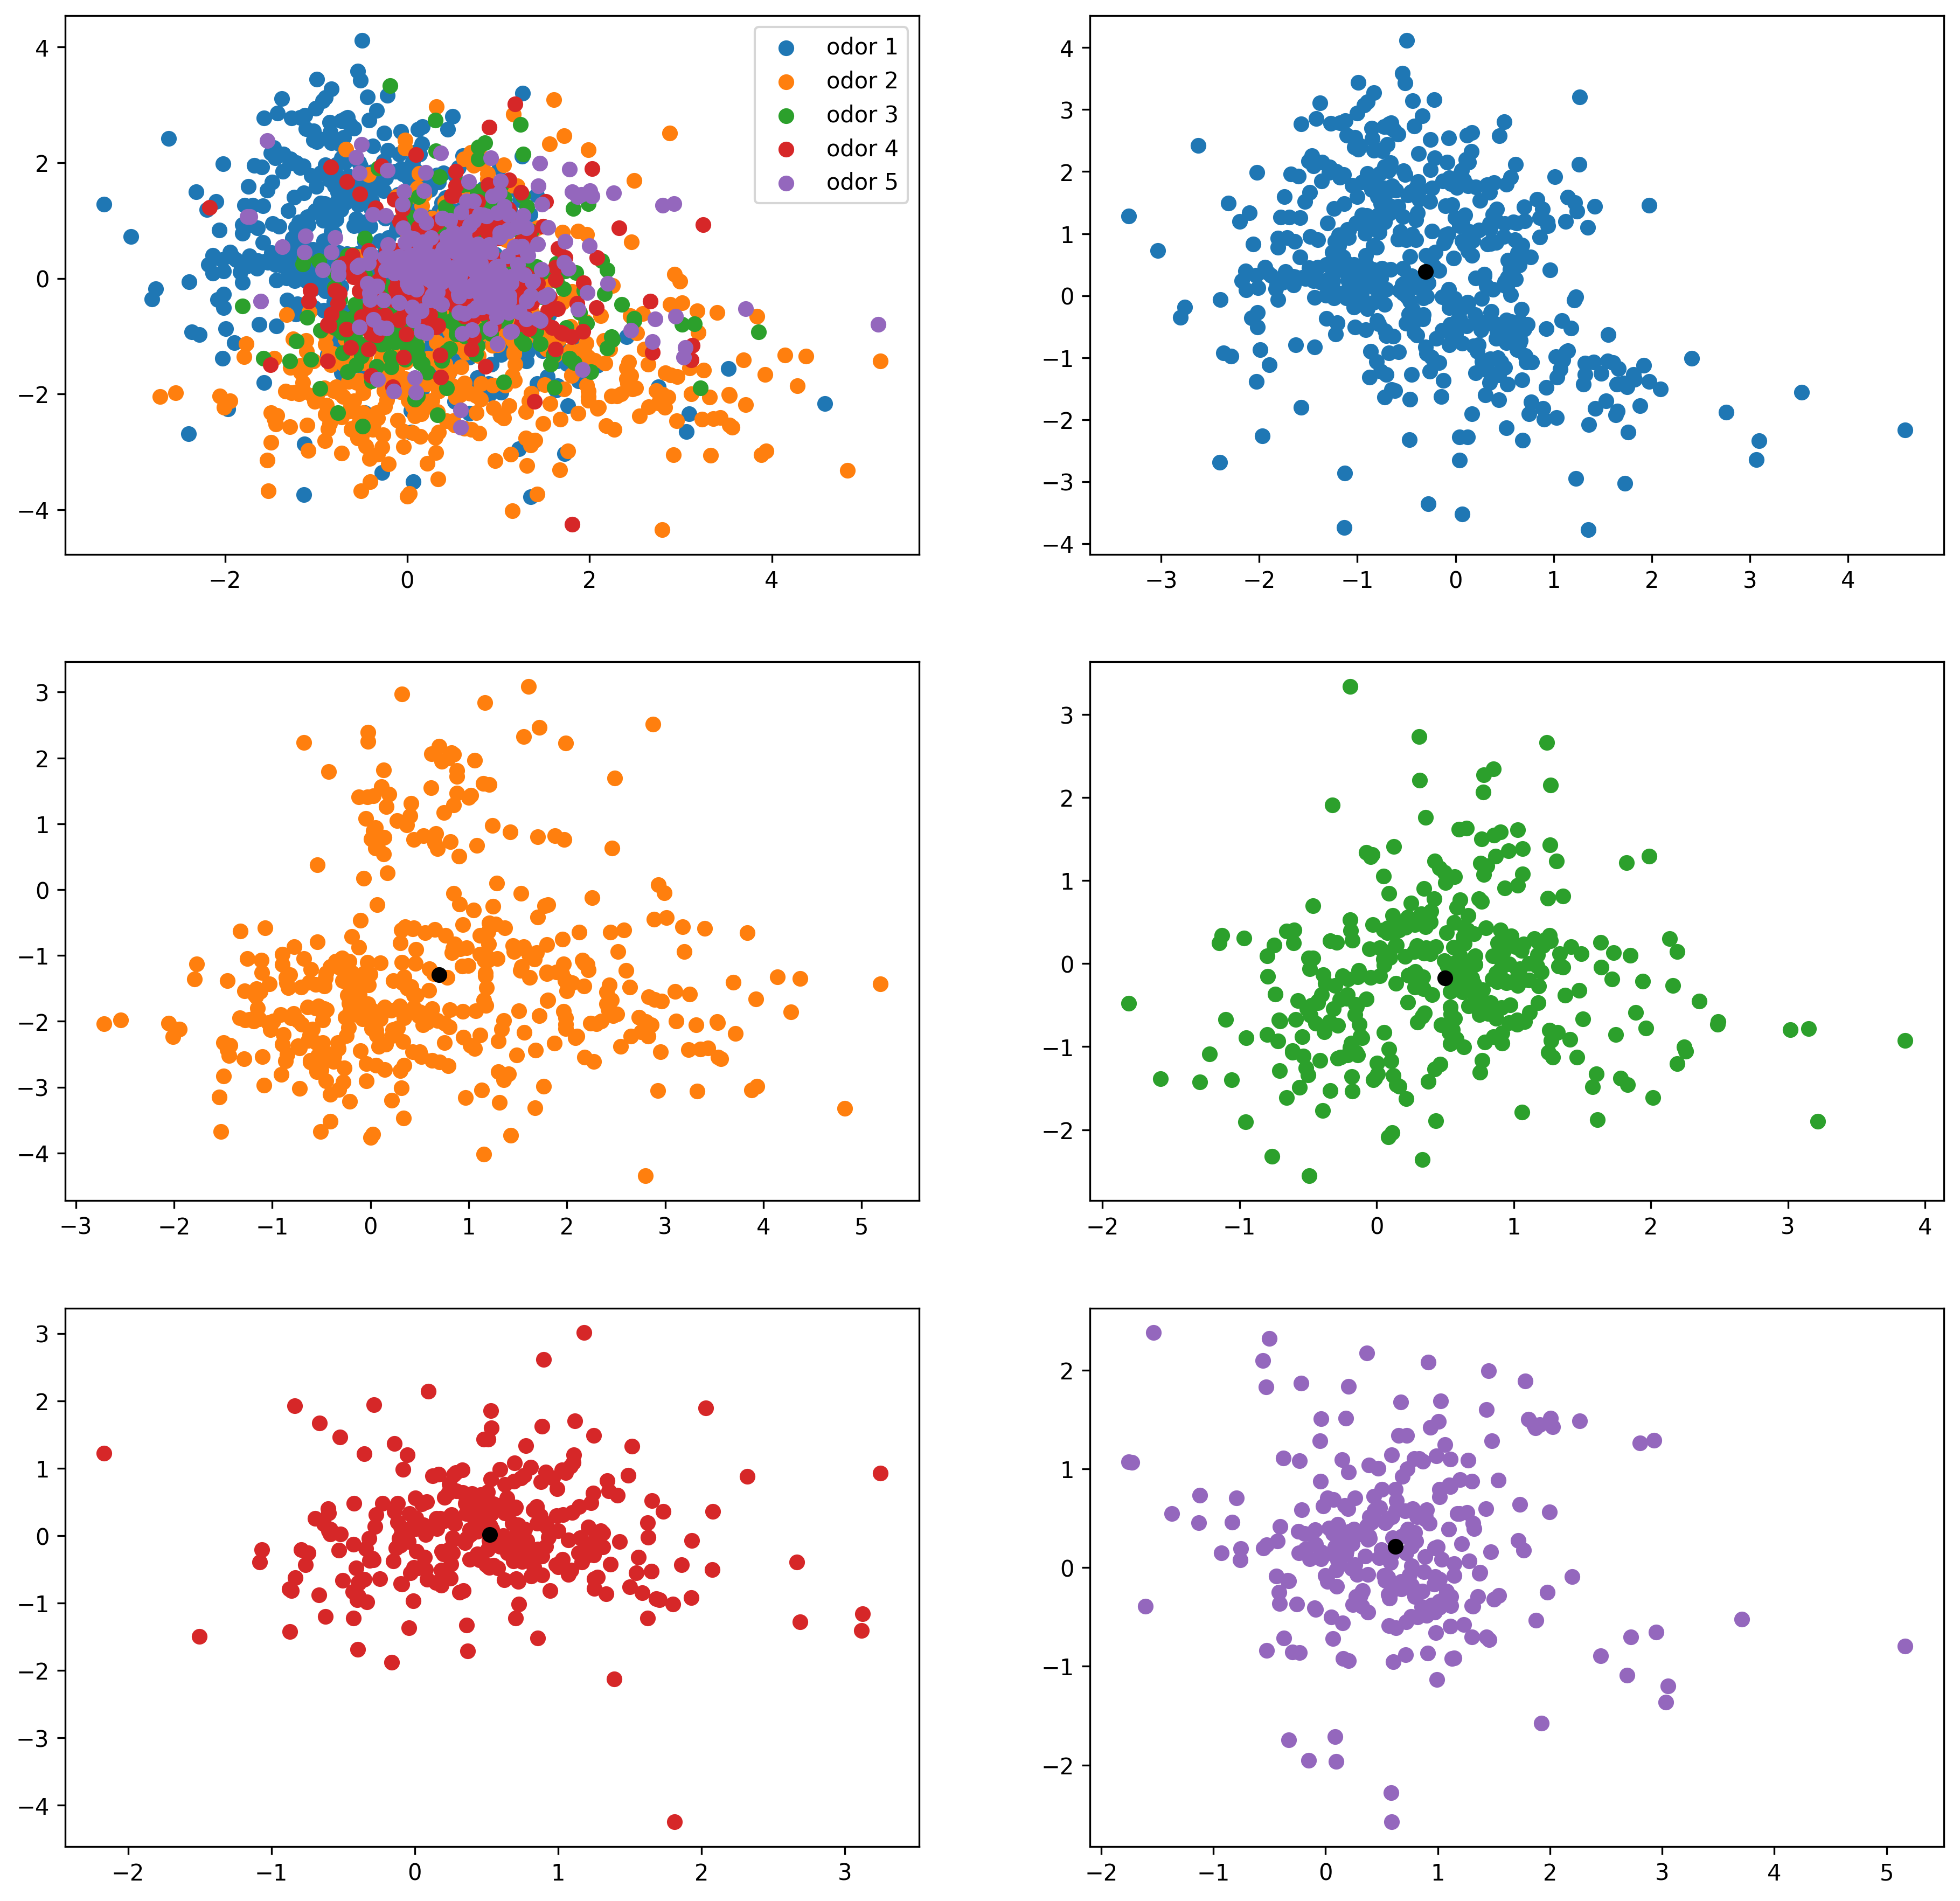

In [ ]:
fig,ax=plt.subplots(3,2,dpi=300)
fig.set_size_inches(15, 15)
for i in range(1,6):
    ax[0,0].scatter(Latent_Space[odor_data_final==i][:,0],Latent_Space[odor_data_final==i][:,1],label='odor '+str(i))
    ax[0,0].legend()

i=1
for indx in range(3):
    for idx in range(2):
        if indx==0 and idx==0:
            idx=1
            ax[indx,idx].scatter(Latent_Space[odor_data_final==i][:,0],Latent_Space[odor_data_final==i][:,1],label='odor '+str(i),c=colors[i-1])
            ax[indx,idx].scatter(centroids_list[i-1][0,0],centroids_list[i-1][0,1],color='black')
            i+=1
        if indx==0 and idx==1:
            pass
        else:
            ax[indx,idx].scatter(Latent_Space[odor_data_final==i][:,0],Latent_Space[odor_data_final==i][:,1],label='odor '+str(i),c=colors[i-1])
            ax[indx,idx].scatter(centroids_list[i-1][0,0],centroids_list[i-1][0,1],color='black')
            i+=1

fig.

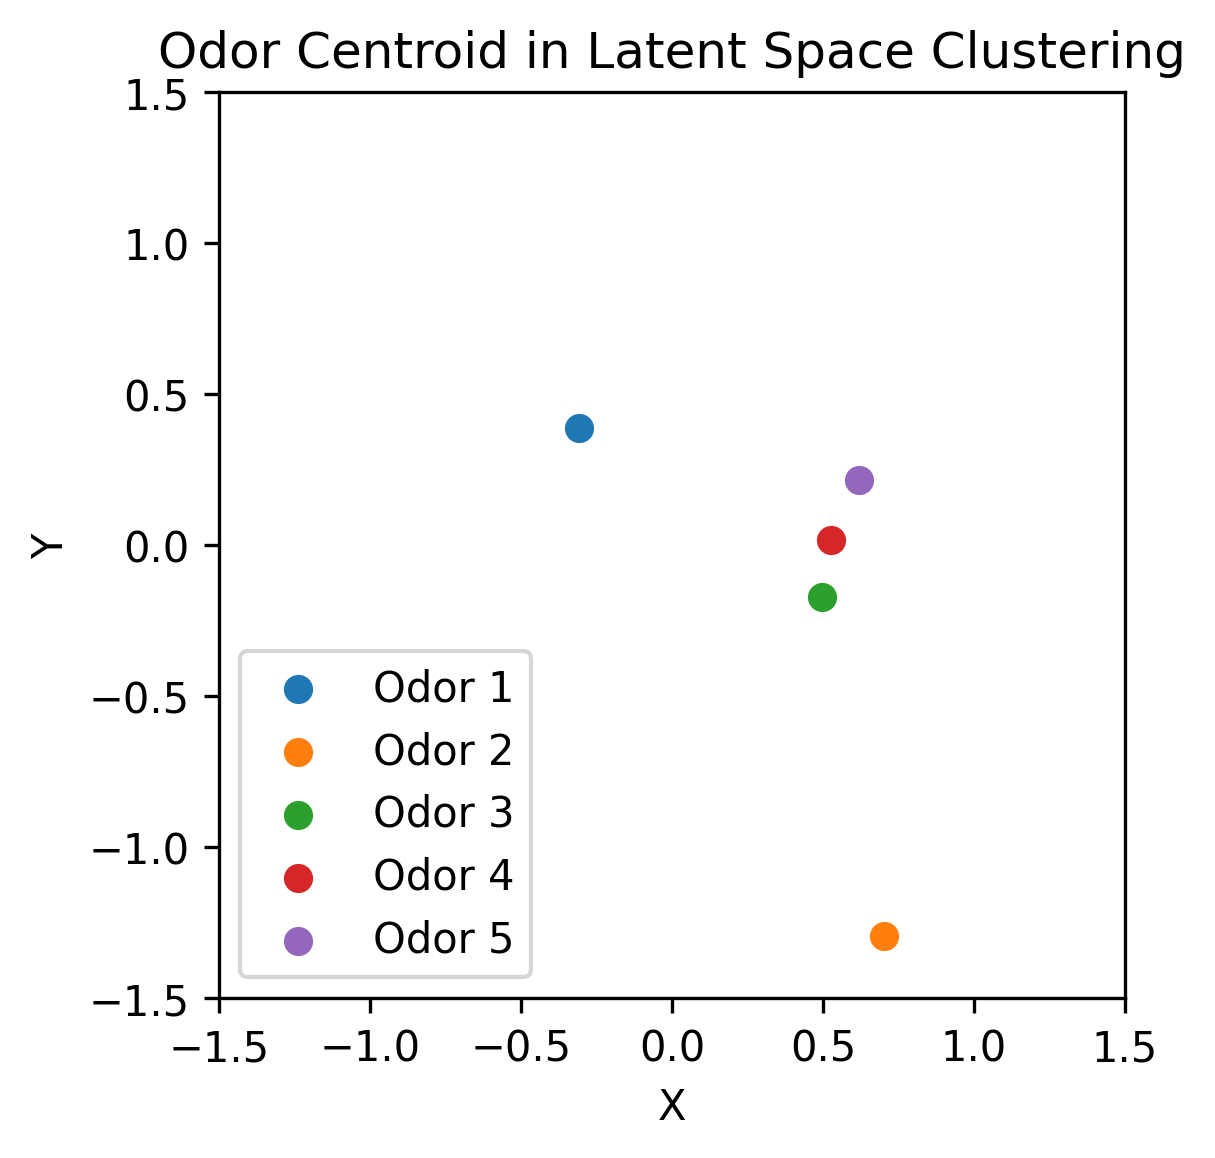

In [176]:
plt.figure(dpi=300)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.gca().set_aspect('equal')
for i in range(1,6):
    plt.scatter(centroids_list[i-1][0,0],centroids_list[i-1][0,1],label='Odor '+str(i))
plt.title('Odor Centroid in Latent Space Clustering')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='lower left')

In [100]:
generated_data=model.sample_data(10)
generated_data=generated_data.detach().numpy()

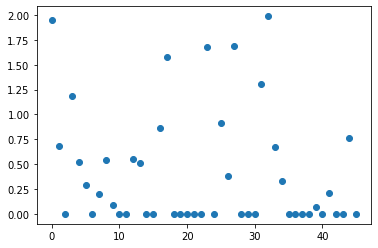

In [113]:
plt.scatter(np.arange(46),generated_data[0])

In [ ]:
#np.savetxt('David Spike Data.csv',spike_data_final,delimiter=',')

In [ ]:
#np.savetxt('David Odor Data.csv',odor_data_final,delimiter=',')

In [ ]:
#np.savetxt('Latent Space.csv',Latent_Space,delimiter=',')
#np.savetxt('odor_data_final.csv',odor_data_final,delimiter=',')

In [ ]:
#torch.save(model,'VAE2_Best.pth')